In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
from tqdm import tqdm

2024-07-07 17:57:58.045288: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 17:57:58.045410: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 17:57:58.174275: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Nomor 3a

Arsitektur yang ditampilkan dalam gambar ini menggambarkan prinsip kerja dasar dari Generative Adversarial Network (GAN). Sistem ini terdiri dari dua komponen utama yang saling bersaing yakni Generator dan Discriminator. Proses dimulai dengan Generator, yang menerima input berupa random noise. Melalui serangkaian layer neural network yang ditunjukkan oleh kotak-kotak hijau, Generator mengubah noise ini menjadi fake image yang berusaha menyerupai gambar dari training set. Training set sendiri adalah kumpulan gambar asli yang berfungsi sebagai referensi dan standar bagi kedua komponen. Gambar palsu yang dihasilkan Generator kemudian diumpankan ke Discriminator, bersama dengan gambar asli dari training set. Discriminator, yang direpresentasikan oleh kotak-kotak merah muda, bertugas untuk membedakan antara gambar asli dan palsu. Ia menganalisis kedua jenis gambar ini dan mencoba mengklasifikasikannya sebagai "Real" atau "Fake". Proses pembelajaran terjadi melalui kompetisi yang berkelanjutan antara kedua komponen ini. Generator terus berupaya memperbaiki kualitas gambar palsunya berdasarkan feedback dari Discriminator, sementara Discriminator terus meningkatkan kemampuannya dalam mendeteksi gambar palsu. Melalui proses adversarial yang iteratif ini, kualitas gambar yang dihasilkan oleh Generator secara bertahap meningkat, dengan tujuan akhir menghasilkan gambar yang sangat mirip dengan gambar asli sehingga sulit dibedakan oleh Discriminator.

# Nomor 3b

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

train_mask = np.isin(train_labels, [0, 1])
test_mask = np.isin(test_labels, [0, 1])

train_images, train_labels = train_images[train_mask], train_labels[train_mask]
test_images, test_labels = test_images[test_mask], test_labels[test_mask]

train_images = (train_images - 127.5) / 127.5
test_images = (test_images - 127.5) / 127.5

train_images = train_images[..., np.newaxis]
test_images = test_images[..., np.newaxis]

print("Train set:")
print(f"T-shirts/tops (Label 0): {np.sum(train_labels == 0)}")
print(f"Trousers (Label 1): {np.sum(train_labels == 1)}")
print("\nTest set:")
print(f"T-shirts/tops (Label 0): {np.sum(test_labels == 0)}")
print(f"Trousers (Label 1): {np.sum(test_labels == 1)}")


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train set:
T-shirts/tops (Label 0): 6000
Trousers (Label 1): 6000

Test set:
T-shirts/tops (Label 0): 1000
Trousers (Label 1): 1000


Model Generative Adversarial Network (GAN) yang saya buat berdasarkan soal, terdiri dari dua komponen utama yakni generator dan discriminator. Generator mengambil dua input yaitu vektor noise untuk memasukkan variasi acak dan vektor label untuk menginformasikan kategori gambar yang ingin dihasilkan. Vektor label diubah menjadi representasi lebih rendah melalui lapisan embedding, yang kemudian digabungkan dengan vektor noise untuk membentuk input gabungan. Generator menggunakan serangkaian lapisan Dense untuk mengubah input gabungan menjadi gambar grayscale 28x28 piksel yang diharapkan. Di sisi lain, discriminator menerima input berupa gambar, baik dari dataset asli maupun hasil generasi generator, dan memprosesnya melalui lapisan-lapisan Dense untuk menghasilkan output yang mencoba membedakan antara gambar asli dan palsu dengan mengeluarkan probabilitas. Kedua model ini di-train secara bersamaan dengan menggunakan BinaryCrossentropy sebagai fungsi loss, dan dioptimalkan menggunakan Adam optimizer dengan learning rate 1e-4. Proses pelatihan GAN ini berfokus pada dinamika adu balik di mana generator berusaha untuk meningkatkan kemampuannya dalam mengecoh discriminator, sementara discriminator diperbarui untuk semakin baik dalam membedakan gambar asli dan palsu.

In [11]:
num_labels = 2

# Generator
noise_input = layers.Input(shape=(100,))
label_input = layers.Input(shape=(1,), dtype='int32')

label_embedding = layers.Embedding(num_labels, 50)(label_input)
label_embedding = layers.Flatten()(label_embedding)

combined_input = layers.Concatenate()([noise_input, label_embedding])

x = layers.Dense(128)(combined_input)
x = layers.LeakyReLU()(x)
x = layers.Dense(256)(x)
x = layers.LeakyReLU()(x)
x = layers.Dense(512)(x)
x = layers.LeakyReLU()(x)
x = layers.Dense(1024)(x)
x = layers.LeakyReLU()(x)
x = layers.Dense(28*28)(x)
generator_output = layers.Reshape((28, 28, 1))(x)

generator = models.Model([noise_input, label_input], generator_output)

# Discriminator
input_image = layers.Input(shape=(28, 28, 1))
x = layers.Flatten()(input_image)
x = layers.Dense(512)(x)
x = layers.LeakyReLU()(x)
x = layers.Dense(1024)(x)
x = layers.LeakyReLU()(x)
x = layers.Dense(1024)(x)
x = layers.LeakyReLU()(x)
x = layers.Dense(512)(x)
x = layers.LeakyReLU()(x)
discriminator_output = layers.Dense(1, activation='sigmoid')(x)

discriminator = models.Model(input_image, discriminator_output)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


100%|██████████| 94/94 [00:03<00:00, 30.80it/s]


Epoch 1/500


100%|██████████| 94/94 [00:00<00:00, 157.39it/s]


Epoch 2/500


100%|██████████| 94/94 [00:00<00:00, 151.56it/s]


Epoch 3/500


100%|██████████| 94/94 [00:00<00:00, 157.17it/s]


Epoch 4/500


100%|██████████| 94/94 [00:00<00:00, 156.82it/s]


Epoch 5/500


100%|██████████| 94/94 [00:00<00:00, 159.69it/s]


Epoch 6/500


100%|██████████| 94/94 [00:00<00:00, 154.77it/s]


Epoch 7/500


100%|██████████| 94/94 [00:00<00:00, 158.63it/s]


Epoch 8/500


100%|██████████| 94/94 [00:00<00:00, 159.53it/s]


Epoch 9/500


100%|██████████| 94/94 [00:00<00:00, 156.58it/s]


Epoch 10/500


100%|██████████| 94/94 [00:00<00:00, 158.02it/s]


Epoch 11/500


100%|██████████| 94/94 [00:00<00:00, 157.59it/s]


Epoch 12/500


100%|██████████| 94/94 [00:00<00:00, 159.47it/s]


Epoch 13/500


100%|██████████| 94/94 [00:00<00:00, 146.71it/s]


Epoch 14/500


100%|██████████| 94/94 [00:00<00:00, 156.47it/s]


Epoch 15/500


100%|██████████| 94/94 [00:00<00:00, 158.52it/s]


Epoch 16/500


100%|██████████| 94/94 [00:00<00:00, 158.08it/s]


Epoch 17/500


100%|██████████| 94/94 [00:00<00:00, 141.16it/s]


Epoch 18/500


100%|██████████| 94/94 [00:00<00:00, 143.23it/s]


Epoch 19/500


100%|██████████| 94/94 [00:00<00:00, 152.87it/s]


Epoch 20/500


100%|██████████| 94/94 [00:00<00:00, 159.00it/s]


Epoch 21/500


100%|██████████| 94/94 [00:00<00:00, 158.43it/s]


Epoch 22/500


100%|██████████| 94/94 [00:00<00:00, 156.23it/s]


Epoch 23/500


100%|██████████| 94/94 [00:00<00:00, 161.35it/s]


Epoch 24/500


100%|██████████| 94/94 [00:00<00:00, 157.66it/s]


Epoch 25/500


100%|██████████| 94/94 [00:00<00:00, 158.09it/s]


Epoch 26/500


100%|██████████| 94/94 [00:00<00:00, 159.14it/s]


Epoch 27/500


100%|██████████| 94/94 [00:00<00:00, 158.87it/s]


Epoch 28/500


100%|██████████| 94/94 [00:00<00:00, 156.79it/s]


Epoch 29/500


100%|██████████| 94/94 [00:00<00:00, 151.53it/s]


Epoch 30/500


100%|██████████| 94/94 [00:00<00:00, 159.68it/s]


Epoch 31/500


100%|██████████| 94/94 [00:00<00:00, 158.24it/s]


Epoch 32/500


100%|██████████| 94/94 [00:00<00:00, 158.16it/s]


Epoch 33/500


100%|██████████| 94/94 [00:00<00:00, 158.84it/s]


Epoch 34/500


100%|██████████| 94/94 [00:00<00:00, 158.94it/s]


Epoch 35/500


100%|██████████| 94/94 [00:00<00:00, 159.80it/s]


Epoch 36/500


100%|██████████| 94/94 [00:00<00:00, 158.46it/s]


Epoch 37/500


100%|██████████| 94/94 [00:00<00:00, 153.85it/s]


Epoch 38/500


100%|██████████| 94/94 [00:00<00:00, 155.94it/s]


Epoch 39/500


100%|██████████| 94/94 [00:00<00:00, 158.31it/s]


Epoch 40/500


100%|██████████| 94/94 [00:00<00:00, 156.79it/s]


Epoch 41/500


100%|██████████| 94/94 [00:00<00:00, 155.18it/s]


Epoch 42/500


100%|██████████| 94/94 [00:00<00:00, 155.04it/s]


Epoch 43/500


100%|██████████| 94/94 [00:00<00:00, 156.21it/s]


Epoch 44/500


100%|██████████| 94/94 [00:00<00:00, 154.79it/s]


Epoch 45/500


100%|██████████| 94/94 [00:00<00:00, 156.75it/s]


Epoch 46/500


100%|██████████| 94/94 [00:00<00:00, 151.45it/s]


Epoch 47/500


100%|██████████| 94/94 [00:00<00:00, 157.00it/s]


Epoch 48/500


100%|██████████| 94/94 [00:00<00:00, 158.22it/s]


Epoch 49/500


100%|██████████| 94/94 [00:00<00:00, 155.80it/s]


Epoch 50/500


100%|██████████| 94/94 [00:00<00:00, 156.92it/s]


Epoch 51/500


100%|██████████| 94/94 [00:00<00:00, 154.77it/s]


Epoch 52/500


100%|██████████| 94/94 [00:00<00:00, 148.13it/s]


Epoch 53/500


100%|██████████| 94/94 [00:00<00:00, 147.70it/s]


Epoch 54/500


100%|██████████| 94/94 [00:00<00:00, 154.75it/s]


Epoch 55/500


100%|██████████| 94/94 [00:00<00:00, 158.55it/s]


Epoch 56/500


100%|██████████| 94/94 [00:00<00:00, 157.77it/s]


Epoch 57/500


100%|██████████| 94/94 [00:00<00:00, 158.00it/s]


Epoch 58/500


100%|██████████| 94/94 [00:00<00:00, 156.66it/s]


Epoch 59/500


100%|██████████| 94/94 [00:00<00:00, 155.84it/s]


Epoch 60/500


100%|██████████| 94/94 [00:00<00:00, 156.87it/s]


Epoch 61/500


100%|██████████| 94/94 [00:00<00:00, 156.22it/s]


Epoch 62/500


100%|██████████| 94/94 [00:00<00:00, 150.12it/s]


Epoch 63/500


100%|██████████| 94/94 [00:00<00:00, 159.31it/s]


Epoch 64/500


100%|██████████| 94/94 [00:00<00:00, 158.69it/s]


Epoch 65/500


100%|██████████| 94/94 [00:00<00:00, 156.09it/s]


Epoch 66/500


100%|██████████| 94/94 [00:00<00:00, 158.78it/s]


Epoch 67/500


100%|██████████| 94/94 [00:00<00:00, 158.83it/s]


Epoch 68/500


100%|██████████| 94/94 [00:00<00:00, 160.20it/s]


Epoch 69/500


100%|██████████| 94/94 [00:00<00:00, 142.62it/s]


Epoch 70/500


100%|██████████| 94/94 [00:00<00:00, 138.17it/s]


Epoch 71/500


100%|██████████| 94/94 [00:00<00:00, 153.66it/s]


Epoch 72/500


100%|██████████| 94/94 [00:00<00:00, 159.08it/s]


Epoch 73/500


100%|██████████| 94/94 [00:00<00:00, 158.00it/s]


Epoch 74/500


100%|██████████| 94/94 [00:00<00:00, 160.92it/s]


Epoch 75/500


100%|██████████| 94/94 [00:00<00:00, 158.54it/s]


Epoch 76/500


100%|██████████| 94/94 [00:00<00:00, 158.98it/s]


Epoch 77/500


100%|██████████| 94/94 [00:00<00:00, 158.11it/s]


Epoch 78/500


100%|██████████| 94/94 [00:00<00:00, 159.96it/s]


Epoch 79/500


100%|██████████| 94/94 [00:00<00:00, 154.02it/s]


Epoch 80/500


100%|██████████| 94/94 [00:00<00:00, 158.63it/s]


Epoch 81/500


100%|██████████| 94/94 [00:00<00:00, 161.30it/s]


Epoch 82/500


100%|██████████| 94/94 [00:00<00:00, 156.93it/s]


Epoch 83/500


100%|██████████| 94/94 [00:00<00:00, 159.99it/s]


Epoch 84/500


100%|██████████| 94/94 [00:00<00:00, 157.09it/s]


Epoch 85/500


100%|██████████| 94/94 [00:00<00:00, 158.75it/s]


Epoch 86/500


100%|██████████| 94/94 [00:00<00:00, 153.63it/s]


Epoch 87/500


100%|██████████| 94/94 [00:00<00:00, 156.96it/s]


Epoch 88/500


100%|██████████| 94/94 [00:00<00:00, 159.41it/s]


Epoch 89/500


100%|██████████| 94/94 [00:00<00:00, 158.23it/s]


Epoch 90/500


100%|██████████| 94/94 [00:00<00:00, 160.93it/s]


Epoch 91/500


100%|██████████| 94/94 [00:00<00:00, 159.15it/s]


Epoch 92/500


100%|██████████| 94/94 [00:00<00:00, 150.38it/s]


Epoch 93/500


100%|██████████| 94/94 [00:00<00:00, 157.65it/s]


Epoch 94/500


100%|██████████| 94/94 [00:00<00:00, 158.46it/s]


Epoch 95/500


100%|██████████| 94/94 [00:00<00:00, 156.57it/s]


Epoch 96/500


100%|██████████| 94/94 [00:00<00:00, 152.92it/s]


Epoch 97/500


100%|██████████| 94/94 [00:00<00:00, 153.88it/s]


Epoch 98/500


100%|██████████| 94/94 [00:00<00:00, 157.69it/s]


Epoch 99/500


100%|██████████| 94/94 [00:00<00:00, 158.42it/s]


Epoch 100/500


100%|██████████| 94/94 [00:00<00:00, 159.72it/s]


Epoch 101/500


100%|██████████| 94/94 [00:00<00:00, 158.76it/s]


Epoch 102/500


100%|██████████| 94/94 [00:00<00:00, 157.90it/s]


Epoch 103/500


100%|██████████| 94/94 [00:00<00:00, 147.54it/s]


Epoch 104/500


100%|██████████| 94/94 [00:00<00:00, 155.25it/s]


Epoch 105/500


100%|██████████| 94/94 [00:00<00:00, 156.60it/s]


Epoch 106/500


100%|██████████| 94/94 [00:00<00:00, 157.96it/s]


Epoch 107/500


100%|██████████| 94/94 [00:00<00:00, 157.91it/s]


Epoch 108/500


100%|██████████| 94/94 [00:00<00:00, 157.00it/s]


Epoch 109/500


100%|██████████| 94/94 [00:00<00:00, 159.76it/s]


Epoch 110/500


100%|██████████| 94/94 [00:00<00:00, 157.57it/s]


Epoch 111/500


100%|██████████| 94/94 [00:00<00:00, 158.26it/s]


Epoch 112/500


100%|██████████| 94/94 [00:00<00:00, 150.88it/s]


Epoch 113/500


100%|██████████| 94/94 [00:00<00:00, 158.19it/s]


Epoch 114/500


100%|██████████| 94/94 [00:00<00:00, 157.67it/s]


Epoch 115/500


100%|██████████| 94/94 [00:00<00:00, 157.46it/s]


Epoch 116/500


100%|██████████| 94/94 [00:00<00:00, 157.89it/s]


Epoch 117/500


100%|██████████| 94/94 [00:00<00:00, 157.77it/s]


Epoch 118/500


100%|██████████| 94/94 [00:00<00:00, 157.24it/s]


Epoch 119/500


100%|██████████| 94/94 [00:00<00:00, 157.81it/s]


Epoch 120/500


100%|██████████| 94/94 [00:00<00:00, 153.19it/s]


Epoch 121/500


100%|██████████| 94/94 [00:00<00:00, 146.04it/s]


Epoch 122/500


100%|██████████| 94/94 [00:00<00:00, 142.26it/s]


Epoch 123/500


100%|██████████| 94/94 [00:00<00:00, 153.21it/s]


Epoch 124/500


100%|██████████| 94/94 [00:00<00:00, 160.71it/s]


Epoch 125/500


100%|██████████| 94/94 [00:00<00:00, 159.88it/s]


Epoch 126/500


100%|██████████| 94/94 [00:00<00:00, 156.25it/s]


Epoch 127/500


100%|██████████| 94/94 [00:00<00:00, 158.12it/s]


Epoch 128/500


100%|██████████| 94/94 [00:00<00:00, 155.81it/s]


Epoch 129/500


100%|██████████| 94/94 [00:00<00:00, 158.35it/s]


Epoch 130/500


100%|██████████| 94/94 [00:00<00:00, 158.96it/s]


Epoch 131/500


100%|██████████| 94/94 [00:00<00:00, 158.18it/s]


Epoch 132/500


100%|██████████| 94/94 [00:00<00:00, 160.42it/s]


Epoch 133/500


100%|██████████| 94/94 [00:00<00:00, 159.24it/s]


Epoch 134/500


100%|██████████| 94/94 [00:00<00:00, 159.74it/s]


Epoch 135/500


100%|██████████| 94/94 [00:00<00:00, 155.97it/s]


Epoch 136/500


100%|██████████| 94/94 [00:00<00:00, 155.21it/s]


Epoch 137/500


100%|██████████| 94/94 [00:00<00:00, 159.68it/s]


Epoch 138/500


100%|██████████| 94/94 [00:00<00:00, 158.04it/s]


Epoch 139/500


100%|██████████| 94/94 [00:00<00:00, 158.66it/s]


Epoch 140/500


100%|██████████| 94/94 [00:00<00:00, 156.59it/s]


Epoch 141/500


100%|██████████| 94/94 [00:00<00:00, 159.92it/s]


Epoch 142/500


100%|██████████| 94/94 [00:00<00:00, 158.25it/s]


Epoch 143/500


100%|██████████| 94/94 [00:00<00:00, 156.88it/s]


Epoch 144/500


100%|██████████| 94/94 [00:00<00:00, 155.33it/s]


Epoch 145/500


100%|██████████| 94/94 [00:00<00:00, 151.40it/s]


Epoch 146/500


100%|██████████| 94/94 [00:00<00:00, 160.20it/s]


Epoch 147/500


100%|██████████| 94/94 [00:00<00:00, 160.23it/s]


Epoch 148/500


100%|██████████| 94/94 [00:00<00:00, 159.03it/s]


Epoch 149/500


100%|██████████| 94/94 [00:00<00:00, 158.10it/s]


Epoch 150/500


100%|██████████| 94/94 [00:00<00:00, 157.59it/s]


Epoch 151/500


100%|██████████| 94/94 [00:00<00:00, 156.48it/s]


Epoch 152/500


100%|██████████| 94/94 [00:00<00:00, 156.91it/s]


Epoch 153/500


100%|██████████| 94/94 [00:00<00:00, 146.80it/s]


Epoch 154/500


100%|██████████| 94/94 [00:00<00:00, 157.84it/s]


Epoch 155/500


100%|██████████| 94/94 [00:00<00:00, 157.68it/s]


Epoch 156/500


100%|██████████| 94/94 [00:00<00:00, 156.87it/s]


Epoch 157/500


100%|██████████| 94/94 [00:00<00:00, 160.68it/s]


Epoch 158/500


100%|██████████| 94/94 [00:00<00:00, 157.14it/s]


Epoch 159/500


100%|██████████| 94/94 [00:00<00:00, 157.49it/s]


Epoch 160/500


100%|██████████| 94/94 [00:00<00:00, 158.61it/s]


Epoch 161/500


100%|██████████| 94/94 [00:00<00:00, 159.14it/s]


Epoch 162/500


100%|██████████| 94/94 [00:00<00:00, 153.20it/s]


Epoch 163/500


100%|██████████| 94/94 [00:00<00:00, 159.20it/s]


Epoch 164/500


100%|██████████| 94/94 [00:00<00:00, 158.63it/s]


Epoch 165/500


100%|██████████| 94/94 [00:00<00:00, 158.04it/s]


Epoch 166/500


100%|██████████| 94/94 [00:00<00:00, 158.62it/s]


Epoch 167/500


100%|██████████| 94/94 [00:00<00:00, 158.99it/s]


Epoch 168/500


100%|██████████| 94/94 [00:00<00:00, 159.27it/s]


Epoch 169/500


100%|██████████| 94/94 [00:00<00:00, 155.68it/s]


Epoch 170/500


100%|██████████| 94/94 [00:00<00:00, 156.32it/s]


Epoch 171/500


100%|██████████| 94/94 [00:00<00:00, 156.66it/s]


Epoch 172/500


100%|██████████| 94/94 [00:00<00:00, 157.58it/s]


Epoch 173/500


100%|██████████| 94/94 [00:00<00:00, 149.45it/s]


Epoch 174/500


100%|██████████| 94/94 [00:00<00:00, 138.84it/s]


Epoch 175/500


100%|██████████| 94/94 [00:00<00:00, 142.96it/s]


Epoch 176/500


100%|██████████| 94/94 [00:00<00:00, 158.61it/s]


Epoch 177/500


100%|██████████| 94/94 [00:00<00:00, 157.98it/s]


Epoch 178/500


100%|██████████| 94/94 [00:00<00:00, 153.29it/s]


Epoch 179/500


100%|██████████| 94/94 [00:00<00:00, 156.01it/s]


Epoch 180/500


100%|██████████| 94/94 [00:00<00:00, 156.62it/s]


Epoch 181/500


100%|██████████| 94/94 [00:00<00:00, 155.75it/s]


Epoch 182/500


100%|██████████| 94/94 [00:00<00:00, 156.24it/s]


Epoch 183/500


100%|██████████| 94/94 [00:00<00:00, 159.11it/s]


Epoch 184/500


100%|██████████| 94/94 [00:00<00:00, 156.76it/s]


Epoch 185/500


100%|██████████| 94/94 [00:00<00:00, 158.21it/s]


Epoch 186/500


100%|██████████| 94/94 [00:00<00:00, 150.22it/s]


Epoch 187/500


100%|██████████| 94/94 [00:00<00:00, 159.16it/s]


Epoch 188/500


100%|██████████| 94/94 [00:00<00:00, 155.99it/s]


Epoch 189/500


100%|██████████| 94/94 [00:00<00:00, 157.30it/s]


Epoch 190/500


100%|██████████| 94/94 [00:00<00:00, 158.82it/s]


Epoch 191/500


100%|██████████| 94/94 [00:00<00:00, 158.63it/s]


Epoch 192/500


100%|██████████| 94/94 [00:00<00:00, 157.86it/s]


Epoch 193/500


100%|██████████| 94/94 [00:00<00:00, 159.09it/s]


Epoch 194/500


100%|██████████| 94/94 [00:00<00:00, 156.26it/s]


Epoch 195/500


100%|██████████| 94/94 [00:00<00:00, 154.99it/s]


Epoch 196/500


100%|██████████| 94/94 [00:00<00:00, 160.26it/s]


Epoch 197/500


100%|██████████| 94/94 [00:00<00:00, 160.14it/s]


Epoch 198/500


100%|██████████| 94/94 [00:00<00:00, 160.33it/s]


Epoch 199/500


100%|██████████| 94/94 [00:00<00:00, 159.52it/s]


Epoch 200/500


100%|██████████| 94/94 [00:00<00:00, 158.33it/s]


Epoch 201/500


100%|██████████| 94/94 [00:00<00:00, 159.43it/s]


Epoch 202/500


100%|██████████| 94/94 [00:00<00:00, 156.80it/s]


Epoch 203/500


100%|██████████| 94/94 [00:00<00:00, 153.54it/s]


Epoch 204/500


100%|██████████| 94/94 [00:00<00:00, 155.16it/s]


Epoch 205/500


100%|██████████| 94/94 [00:00<00:00, 157.61it/s]


Epoch 206/500


100%|██████████| 94/94 [00:00<00:00, 155.74it/s]


Epoch 207/500


100%|██████████| 94/94 [00:00<00:00, 156.83it/s]


Epoch 208/500


100%|██████████| 94/94 [00:00<00:00, 159.38it/s]


Epoch 209/500


100%|██████████| 94/94 [00:00<00:00, 158.45it/s]


Epoch 210/500


100%|██████████| 94/94 [00:00<00:00, 156.86it/s]


Epoch 211/500


100%|██████████| 94/94 [00:00<00:00, 153.69it/s]


Epoch 212/500


100%|██████████| 94/94 [00:00<00:00, 157.80it/s]


Epoch 213/500


100%|██████████| 94/94 [00:00<00:00, 160.07it/s]


Epoch 214/500


100%|██████████| 94/94 [00:00<00:00, 159.84it/s]


Epoch 215/500


100%|██████████| 94/94 [00:00<00:00, 160.64it/s]


Epoch 216/500


100%|██████████| 94/94 [00:00<00:00, 160.81it/s]


Epoch 217/500


100%|██████████| 94/94 [00:00<00:00, 160.42it/s]


Epoch 218/500


100%|██████████| 94/94 [00:00<00:00, 159.83it/s]


Epoch 219/500


100%|██████████| 94/94 [00:00<00:00, 158.05it/s]


Epoch 220/500


100%|██████████| 94/94 [00:00<00:00, 157.41it/s]


Epoch 221/500


100%|██████████| 94/94 [00:00<00:00, 158.30it/s]


Epoch 222/500


100%|██████████| 94/94 [00:00<00:00, 160.04it/s]


Epoch 223/500


100%|██████████| 94/94 [00:00<00:00, 161.63it/s]


Epoch 224/500


100%|██████████| 94/94 [00:00<00:00, 161.24it/s]


Epoch 225/500


100%|██████████| 94/94 [00:00<00:00, 160.36it/s]


Epoch 226/500


100%|██████████| 94/94 [00:00<00:00, 137.73it/s]


Epoch 227/500


100%|██████████| 94/94 [00:00<00:00, 139.77it/s]


Epoch 228/500


100%|██████████| 94/94 [00:00<00:00, 152.61it/s]


Epoch 229/500


100%|██████████| 94/94 [00:00<00:00, 159.86it/s]


Epoch 230/500


100%|██████████| 94/94 [00:00<00:00, 157.65it/s]


Epoch 231/500


100%|██████████| 94/94 [00:00<00:00, 159.06it/s]


Epoch 232/500


100%|██████████| 94/94 [00:00<00:00, 157.46it/s]


Epoch 233/500


100%|██████████| 94/94 [00:00<00:00, 158.62it/s]


Epoch 234/500


100%|██████████| 94/94 [00:00<00:00, 157.83it/s]


Epoch 235/500


100%|██████████| 94/94 [00:00<00:00, 160.81it/s]


Epoch 236/500


100%|██████████| 94/94 [00:00<00:00, 158.18it/s]


Epoch 237/500


100%|██████████| 94/94 [00:00<00:00, 160.17it/s]


Epoch 238/500


100%|██████████| 94/94 [00:00<00:00, 158.65it/s]


Epoch 239/500


100%|██████████| 94/94 [00:00<00:00, 158.00it/s]


Epoch 240/500


100%|██████████| 94/94 [00:00<00:00, 158.08it/s]


Epoch 241/500


100%|██████████| 94/94 [00:00<00:00, 158.70it/s]


Epoch 242/500


100%|██████████| 94/94 [00:00<00:00, 158.69it/s]


Epoch 243/500


100%|██████████| 94/94 [00:00<00:00, 159.58it/s]


Epoch 244/500


100%|██████████| 94/94 [00:00<00:00, 156.82it/s]


Epoch 245/500


100%|██████████| 94/94 [00:00<00:00, 152.26it/s]


Epoch 246/500


100%|██████████| 94/94 [00:00<00:00, 159.18it/s]


Epoch 247/500


100%|██████████| 94/94 [00:00<00:00, 161.53it/s]


Epoch 248/500


100%|██████████| 94/94 [00:00<00:00, 159.15it/s]


Epoch 249/500


100%|██████████| 94/94 [00:00<00:00, 158.45it/s]


Epoch 250/500


100%|██████████| 94/94 [00:00<00:00, 160.49it/s]


Epoch 251/500


100%|██████████| 94/94 [00:00<00:00, 158.48it/s]


Epoch 252/500


100%|██████████| 94/94 [00:00<00:00, 156.57it/s]


Epoch 253/500


100%|██████████| 94/94 [00:00<00:00, 149.86it/s]


Epoch 254/500


100%|██████████| 94/94 [00:00<00:00, 156.31it/s]


Epoch 255/500


100%|██████████| 94/94 [00:00<00:00, 154.94it/s]


Epoch 256/500


100%|██████████| 94/94 [00:00<00:00, 158.32it/s]


Epoch 257/500


100%|██████████| 94/94 [00:00<00:00, 155.88it/s]


Epoch 258/500


100%|██████████| 94/94 [00:00<00:00, 156.95it/s]


Epoch 259/500


100%|██████████| 94/94 [00:00<00:00, 158.47it/s]


Epoch 260/500


100%|██████████| 94/94 [00:00<00:00, 158.26it/s]


Epoch 261/500


100%|██████████| 94/94 [00:00<00:00, 150.58it/s]


Epoch 262/500


100%|██████████| 94/94 [00:00<00:00, 157.42it/s]


Epoch 263/500


100%|██████████| 94/94 [00:00<00:00, 156.55it/s]


Epoch 264/500


100%|██████████| 94/94 [00:00<00:00, 158.27it/s]


Epoch 265/500


100%|██████████| 94/94 [00:00<00:00, 158.47it/s]


Epoch 266/500


100%|██████████| 94/94 [00:00<00:00, 157.52it/s]


Epoch 267/500


100%|██████████| 94/94 [00:00<00:00, 156.87it/s]


Epoch 268/500


100%|██████████| 94/94 [00:00<00:00, 156.59it/s]


Epoch 269/500


100%|██████████| 94/94 [00:00<00:00, 157.18it/s]


Epoch 270/500


100%|██████████| 94/94 [00:00<00:00, 157.49it/s]


Epoch 271/500


100%|██████████| 94/94 [00:00<00:00, 157.74it/s]


Epoch 272/500


100%|██████████| 94/94 [00:00<00:00, 157.58it/s]


Epoch 273/500


100%|██████████| 94/94 [00:00<00:00, 159.55it/s]


Epoch 274/500


100%|██████████| 94/94 [00:00<00:00, 159.83it/s]


Epoch 275/500


100%|██████████| 94/94 [00:00<00:00, 158.42it/s]


Epoch 276/500


100%|██████████| 94/94 [00:00<00:00, 158.77it/s]


Epoch 277/500


100%|██████████| 94/94 [00:00<00:00, 158.57it/s]


Epoch 278/500


100%|██████████| 94/94 [00:00<00:00, 134.72it/s]


Epoch 279/500


100%|██████████| 94/94 [00:00<00:00, 140.13it/s]


Epoch 280/500


100%|██████████| 94/94 [00:00<00:00, 151.77it/s]


Epoch 281/500


100%|██████████| 94/94 [00:00<00:00, 159.15it/s]


Epoch 282/500


100%|██████████| 94/94 [00:00<00:00, 158.01it/s]


Epoch 283/500


100%|██████████| 94/94 [00:00<00:00, 157.82it/s]


Epoch 284/500


100%|██████████| 94/94 [00:00<00:00, 159.06it/s]


Epoch 285/500


100%|██████████| 94/94 [00:00<00:00, 156.04it/s]


Epoch 286/500


100%|██████████| 94/94 [00:00<00:00, 153.70it/s]


Epoch 287/500


100%|██████████| 94/94 [00:00<00:00, 156.60it/s]


Epoch 288/500


100%|██████████| 94/94 [00:00<00:00, 156.52it/s]


Epoch 289/500


100%|██████████| 94/94 [00:00<00:00, 159.46it/s]


Epoch 290/500


100%|██████████| 94/94 [00:00<00:00, 160.75it/s]


Epoch 291/500


100%|██████████| 94/94 [00:00<00:00, 156.86it/s]


Epoch 292/500


100%|██████████| 94/94 [00:00<00:00, 158.83it/s]


Epoch 293/500


100%|██████████| 94/94 [00:00<00:00, 157.40it/s]


Epoch 294/500


100%|██████████| 94/94 [00:00<00:00, 152.38it/s]


Epoch 295/500


100%|██████████| 94/94 [00:00<00:00, 157.27it/s]


Epoch 296/500


100%|██████████| 94/94 [00:00<00:00, 158.73it/s]


Epoch 297/500


100%|██████████| 94/94 [00:00<00:00, 157.39it/s]


Epoch 298/500


100%|██████████| 94/94 [00:00<00:00, 158.59it/s]


Epoch 299/500


100%|██████████| 94/94 [00:00<00:00, 157.96it/s]


Epoch 300/500


100%|██████████| 94/94 [00:00<00:00, 158.56it/s]


Epoch 301/500


100%|██████████| 94/94 [00:00<00:00, 158.65it/s]


Epoch 302/500


100%|██████████| 94/94 [00:00<00:00, 159.03it/s]


Epoch 303/500


100%|██████████| 94/94 [00:00<00:00, 157.94it/s]


Epoch 304/500


100%|██████████| 94/94 [00:00<00:00, 157.12it/s]


Epoch 305/500


100%|██████████| 94/94 [00:00<00:00, 153.32it/s]


Epoch 306/500


100%|██████████| 94/94 [00:00<00:00, 157.47it/s]


Epoch 307/500


100%|██████████| 94/94 [00:00<00:00, 157.92it/s]


Epoch 308/500


100%|██████████| 94/94 [00:00<00:00, 158.46it/s]


Epoch 309/500


100%|██████████| 94/94 [00:00<00:00, 158.57it/s]


Epoch 310/500


100%|██████████| 94/94 [00:00<00:00, 159.70it/s]


Epoch 311/500


100%|██████████| 94/94 [00:00<00:00, 148.77it/s]


Epoch 312/500


100%|██████████| 94/94 [00:00<00:00, 158.76it/s]


Epoch 313/500


100%|██████████| 94/94 [00:00<00:00, 160.07it/s]


Epoch 314/500


100%|██████████| 94/94 [00:00<00:00, 157.22it/s]


Epoch 315/500


100%|██████████| 94/94 [00:00<00:00, 159.52it/s]


Epoch 316/500


100%|██████████| 94/94 [00:00<00:00, 158.35it/s]


Epoch 317/500


100%|██████████| 94/94 [00:00<00:00, 159.94it/s]


Epoch 318/500


100%|██████████| 94/94 [00:00<00:00, 160.19it/s]


Epoch 319/500


100%|██████████| 94/94 [00:00<00:00, 158.14it/s]


Epoch 320/500


100%|██████████| 94/94 [00:00<00:00, 157.90it/s]


Epoch 321/500


100%|██████████| 94/94 [00:00<00:00, 159.79it/s]


Epoch 322/500


100%|██████████| 94/94 [00:00<00:00, 158.42it/s]


Epoch 323/500


100%|██████████| 94/94 [00:00<00:00, 158.54it/s]


Epoch 324/500


100%|██████████| 94/94 [00:00<00:00, 156.89it/s]


Epoch 325/500


100%|██████████| 94/94 [00:00<00:00, 158.24it/s]


Epoch 326/500


100%|██████████| 94/94 [00:00<00:00, 157.86it/s]


Epoch 327/500


100%|██████████| 94/94 [00:00<00:00, 157.83it/s]


Epoch 328/500


100%|██████████| 94/94 [00:00<00:00, 152.92it/s]


Epoch 329/500


100%|██████████| 94/94 [00:00<00:00, 157.40it/s]


Epoch 330/500


100%|██████████| 94/94 [00:00<00:00, 145.39it/s]


Epoch 331/500


100%|██████████| 94/94 [00:00<00:00, 144.37it/s]


Epoch 332/500


100%|██████████| 94/94 [00:00<00:00, 152.77it/s]


Epoch 333/500


100%|██████████| 94/94 [00:00<00:00, 158.71it/s]


Epoch 334/500


100%|██████████| 94/94 [00:00<00:00, 160.32it/s]


Epoch 335/500


100%|██████████| 94/94 [00:00<00:00, 157.38it/s]


Epoch 336/500


100%|██████████| 94/94 [00:00<00:00, 157.37it/s]


Epoch 337/500


100%|██████████| 94/94 [00:00<00:00, 158.86it/s]


Epoch 338/500


100%|██████████| 94/94 [00:00<00:00, 158.06it/s]


Epoch 339/500


100%|██████████| 94/94 [00:00<00:00, 158.92it/s]


Epoch 340/500


100%|██████████| 94/94 [00:00<00:00, 158.06it/s]


Epoch 341/500


100%|██████████| 94/94 [00:00<00:00, 159.10it/s]


Epoch 342/500


100%|██████████| 94/94 [00:00<00:00, 156.62it/s]


Epoch 343/500


100%|██████████| 94/94 [00:00<00:00, 159.34it/s]


Epoch 344/500


100%|██████████| 94/94 [00:00<00:00, 152.22it/s]


Epoch 345/500


100%|██████████| 94/94 [00:00<00:00, 158.77it/s]


Epoch 346/500


100%|██████████| 94/94 [00:00<00:00, 160.97it/s]


Epoch 347/500


100%|██████████| 94/94 [00:00<00:00, 159.68it/s]


Epoch 348/500


100%|██████████| 94/94 [00:00<00:00, 162.17it/s]


Epoch 349/500


100%|██████████| 94/94 [00:00<00:00, 159.80it/s]


Epoch 350/500


100%|██████████| 94/94 [00:00<00:00, 161.80it/s]


Epoch 351/500


100%|██████████| 94/94 [00:00<00:00, 160.62it/s]


Epoch 352/500


100%|██████████| 94/94 [00:00<00:00, 155.19it/s]


Epoch 353/500


100%|██████████| 94/94 [00:00<00:00, 158.73it/s]


Epoch 354/500


100%|██████████| 94/94 [00:00<00:00, 159.05it/s]


Epoch 355/500


100%|██████████| 94/94 [00:00<00:00, 157.83it/s]


Epoch 356/500


100%|██████████| 94/94 [00:00<00:00, 155.35it/s]


Epoch 357/500


100%|██████████| 94/94 [00:00<00:00, 158.77it/s]


Epoch 358/500


100%|██████████| 94/94 [00:00<00:00, 160.03it/s]


Epoch 359/500


100%|██████████| 94/94 [00:00<00:00, 157.19it/s]


Epoch 360/500


100%|██████████| 94/94 [00:00<00:00, 157.86it/s]


Epoch 361/500


100%|██████████| 94/94 [00:00<00:00, 152.84it/s]


Epoch 362/500


100%|██████████| 94/94 [00:00<00:00, 155.82it/s]


Epoch 363/500


100%|██████████| 94/94 [00:00<00:00, 156.65it/s]


Epoch 364/500


100%|██████████| 94/94 [00:00<00:00, 159.63it/s]


Epoch 365/500


100%|██████████| 94/94 [00:00<00:00, 159.04it/s]


Epoch 366/500


100%|██████████| 94/94 [00:00<00:00, 157.80it/s]


Epoch 367/500


100%|██████████| 94/94 [00:00<00:00, 157.02it/s]


Epoch 368/500


100%|██████████| 94/94 [00:00<00:00, 159.10it/s]


Epoch 369/500


100%|██████████| 94/94 [00:00<00:00, 155.45it/s]


Epoch 370/500


100%|██████████| 94/94 [00:00<00:00, 157.69it/s]


Epoch 371/500


100%|██████████| 94/94 [00:00<00:00, 159.16it/s]


Epoch 372/500


100%|██████████| 94/94 [00:00<00:00, 159.15it/s]


Epoch 373/500


100%|██████████| 94/94 [00:00<00:00, 161.47it/s]


Epoch 374/500


100%|██████████| 94/94 [00:00<00:00, 160.33it/s]


Epoch 375/500


100%|██████████| 94/94 [00:00<00:00, 152.21it/s]


Epoch 376/500


100%|██████████| 94/94 [00:00<00:00, 159.38it/s]


Epoch 377/500


100%|██████████| 94/94 [00:00<00:00, 157.60it/s]


Epoch 378/500


100%|██████████| 94/94 [00:00<00:00, 156.63it/s]


Epoch 379/500


100%|██████████| 94/94 [00:00<00:00, 158.18it/s]


Epoch 380/500


100%|██████████| 94/94 [00:00<00:00, 160.04it/s]


Epoch 381/500


100%|██████████| 94/94 [00:00<00:00, 154.80it/s]


Epoch 382/500


100%|██████████| 94/94 [00:00<00:00, 153.06it/s]


Epoch 383/500


100%|██████████| 94/94 [00:00<00:00, 137.69it/s]


Epoch 384/500


100%|██████████| 94/94 [00:00<00:00, 145.91it/s]


Epoch 385/500


100%|██████████| 94/94 [00:00<00:00, 154.05it/s]


Epoch 386/500


100%|██████████| 94/94 [00:00<00:00, 153.00it/s]


Epoch 387/500


100%|██████████| 94/94 [00:00<00:00, 155.53it/s]


Epoch 388/500


100%|██████████| 94/94 [00:00<00:00, 158.69it/s]


Epoch 389/500


100%|██████████| 94/94 [00:00<00:00, 158.27it/s]


Epoch 390/500


100%|██████████| 94/94 [00:00<00:00, 156.76it/s]


Epoch 391/500


100%|██████████| 94/94 [00:00<00:00, 158.32it/s]


Epoch 392/500


100%|██████████| 94/94 [00:00<00:00, 157.86it/s]


Epoch 393/500


100%|██████████| 94/94 [00:00<00:00, 157.32it/s]


Epoch 394/500


100%|██████████| 94/94 [00:00<00:00, 152.63it/s]


Epoch 395/500


100%|██████████| 94/94 [00:00<00:00, 157.46it/s]


Epoch 396/500


100%|██████████| 94/94 [00:00<00:00, 156.48it/s]


Epoch 397/500


100%|██████████| 94/94 [00:00<00:00, 157.99it/s]


Epoch 398/500


100%|██████████| 94/94 [00:00<00:00, 158.14it/s]


Epoch 399/500


100%|██████████| 94/94 [00:00<00:00, 160.39it/s]


Epoch 400/500


100%|██████████| 94/94 [00:00<00:00, 156.28it/s]


Epoch 401/500


100%|██████████| 94/94 [00:00<00:00, 159.90it/s]


Epoch 402/500


100%|██████████| 94/94 [00:00<00:00, 157.33it/s]


Epoch 403/500


100%|██████████| 94/94 [00:00<00:00, 161.91it/s]


Epoch 404/500


100%|██████████| 94/94 [00:00<00:00, 160.24it/s]


Epoch 405/500


100%|██████████| 94/94 [00:00<00:00, 157.07it/s]


Epoch 406/500


100%|██████████| 94/94 [00:00<00:00, 155.14it/s]


Epoch 407/500


100%|██████████| 94/94 [00:00<00:00, 155.99it/s]


Epoch 408/500


100%|██████████| 94/94 [00:00<00:00, 156.79it/s]


Epoch 409/500


100%|██████████| 94/94 [00:00<00:00, 157.97it/s]


Epoch 410/500


100%|██████████| 94/94 [00:00<00:00, 153.97it/s]


Epoch 411/500


100%|██████████| 94/94 [00:00<00:00, 152.84it/s]


Epoch 412/500


100%|██████████| 94/94 [00:00<00:00, 152.89it/s]


Epoch 413/500


100%|██████████| 94/94 [00:00<00:00, 156.23it/s]


Epoch 414/500


100%|██████████| 94/94 [00:00<00:00, 158.67it/s]


Epoch 415/500


100%|██████████| 94/94 [00:00<00:00, 158.71it/s]


Epoch 416/500


100%|██████████| 94/94 [00:00<00:00, 159.64it/s]


Epoch 417/500


100%|██████████| 94/94 [00:00<00:00, 159.77it/s]


Epoch 418/500


100%|██████████| 94/94 [00:00<00:00, 157.50it/s]


Epoch 419/500


100%|██████████| 94/94 [00:00<00:00, 157.13it/s]


Epoch 420/500


100%|██████████| 94/94 [00:00<00:00, 156.43it/s]


Epoch 421/500


100%|██████████| 94/94 [00:00<00:00, 157.31it/s]


Epoch 422/500


100%|██████████| 94/94 [00:00<00:00, 156.63it/s]


Epoch 423/500


100%|██████████| 94/94 [00:00<00:00, 157.25it/s]


Epoch 424/500


100%|██████████| 94/94 [00:00<00:00, 159.81it/s]


Epoch 425/500


100%|██████████| 94/94 [00:00<00:00, 158.26it/s]


Epoch 426/500


100%|██████████| 94/94 [00:00<00:00, 159.02it/s]


Epoch 427/500


100%|██████████| 94/94 [00:00<00:00, 151.58it/s]


Epoch 428/500


100%|██████████| 94/94 [00:00<00:00, 157.88it/s]


Epoch 429/500


100%|██████████| 94/94 [00:00<00:00, 158.62it/s]


Epoch 430/500


100%|██████████| 94/94 [00:00<00:00, 158.50it/s]


Epoch 431/500


100%|██████████| 94/94 [00:00<00:00, 161.54it/s]


Epoch 432/500


100%|██████████| 94/94 [00:00<00:00, 155.51it/s]


Epoch 433/500


100%|██████████| 94/94 [00:00<00:00, 158.73it/s]


Epoch 434/500


100%|██████████| 94/94 [00:00<00:00, 159.24it/s]


Epoch 435/500


100%|██████████| 94/94 [00:00<00:00, 136.16it/s]


Epoch 436/500


100%|██████████| 94/94 [00:00<00:00, 146.54it/s]


Epoch 437/500


100%|██████████| 94/94 [00:00<00:00, 157.05it/s]


Epoch 438/500


100%|██████████| 94/94 [00:00<00:00, 160.28it/s]


Epoch 439/500


100%|██████████| 94/94 [00:00<00:00, 161.19it/s]


Epoch 440/500


100%|██████████| 94/94 [00:00<00:00, 159.16it/s]


Epoch 441/500


100%|██████████| 94/94 [00:00<00:00, 161.21it/s]


Epoch 442/500


100%|██████████| 94/94 [00:00<00:00, 158.21it/s]


Epoch 443/500


100%|██████████| 94/94 [00:00<00:00, 160.70it/s]


Epoch 444/500


100%|██████████| 94/94 [00:00<00:00, 153.34it/s]


Epoch 445/500


100%|██████████| 94/94 [00:00<00:00, 157.86it/s]


Epoch 446/500


100%|██████████| 94/94 [00:00<00:00, 160.51it/s]


Epoch 447/500


100%|██████████| 94/94 [00:00<00:00, 157.82it/s]


Epoch 448/500


100%|██████████| 94/94 [00:00<00:00, 160.62it/s]


Epoch 449/500


100%|██████████| 94/94 [00:00<00:00, 157.38it/s]


Epoch 450/500


100%|██████████| 94/94 [00:00<00:00, 158.25it/s]


Epoch 451/500


100%|██████████| 94/94 [00:00<00:00, 159.53it/s]


Epoch 452/500


100%|██████████| 94/94 [00:00<00:00, 153.38it/s]


Epoch 453/500


100%|██████████| 94/94 [00:00<00:00, 159.80it/s]


Epoch 454/500


100%|██████████| 94/94 [00:00<00:00, 157.99it/s]


Epoch 455/500


100%|██████████| 94/94 [00:00<00:00, 157.84it/s]


Epoch 456/500


100%|██████████| 94/94 [00:00<00:00, 157.71it/s]


Epoch 457/500


100%|██████████| 94/94 [00:00<00:00, 150.90it/s]


Epoch 458/500


100%|██████████| 94/94 [00:00<00:00, 159.60it/s]


Epoch 459/500


100%|██████████| 94/94 [00:00<00:00, 159.51it/s]


Epoch 460/500


100%|██████████| 94/94 [00:00<00:00, 157.55it/s]


Epoch 461/500


100%|██████████| 94/94 [00:00<00:00, 153.87it/s]


Epoch 462/500


100%|██████████| 94/94 [00:00<00:00, 146.94it/s]


Epoch 463/500


100%|██████████| 94/94 [00:00<00:00, 148.04it/s]


Epoch 464/500


100%|██████████| 94/94 [00:00<00:00, 157.93it/s]


Epoch 465/500


100%|██████████| 94/94 [00:00<00:00, 157.41it/s]


Epoch 466/500


100%|██████████| 94/94 [00:00<00:00, 161.16it/s]


Epoch 467/500


100%|██████████| 94/94 [00:00<00:00, 158.81it/s]


Epoch 468/500


100%|██████████| 94/94 [00:00<00:00, 157.43it/s]


Epoch 469/500


100%|██████████| 94/94 [00:00<00:00, 156.92it/s]


Epoch 470/500


100%|██████████| 94/94 [00:00<00:00, 158.43it/s]


Epoch 471/500


100%|██████████| 94/94 [00:00<00:00, 160.74it/s]


Epoch 472/500


100%|██████████| 94/94 [00:00<00:00, 157.63it/s]


Epoch 473/500


100%|██████████| 94/94 [00:00<00:00, 160.50it/s]


Epoch 474/500


100%|██████████| 94/94 [00:00<00:00, 158.45it/s]


Epoch 475/500


100%|██████████| 94/94 [00:00<00:00, 156.19it/s]


Epoch 476/500


100%|██████████| 94/94 [00:00<00:00, 159.42it/s]


Epoch 477/500


100%|██████████| 94/94 [00:00<00:00, 152.46it/s]


Epoch 478/500


100%|██████████| 94/94 [00:00<00:00, 159.38it/s]


Epoch 479/500


100%|██████████| 94/94 [00:00<00:00, 157.30it/s]


Epoch 480/500


100%|██████████| 94/94 [00:00<00:00, 157.34it/s]


Epoch 481/500


100%|██████████| 94/94 [00:00<00:00, 157.99it/s]


Epoch 482/500


100%|██████████| 94/94 [00:00<00:00, 161.46it/s]


Epoch 483/500


100%|██████████| 94/94 [00:00<00:00, 161.13it/s]


Epoch 484/500


100%|██████████| 94/94 [00:00<00:00, 160.23it/s]


Epoch 485/500


100%|██████████| 94/94 [00:00<00:00, 157.33it/s]


Epoch 486/500


100%|██████████| 94/94 [00:00<00:00, 155.33it/s]


Epoch 487/500


100%|██████████| 94/94 [00:00<00:00, 142.20it/s]


Epoch 488/500


100%|██████████| 94/94 [00:00<00:00, 143.90it/s]


Epoch 489/500


100%|██████████| 94/94 [00:00<00:00, 158.70it/s]


Epoch 490/500


100%|██████████| 94/94 [00:00<00:00, 155.96it/s]


Epoch 491/500


100%|██████████| 94/94 [00:00<00:00, 159.03it/s]


Epoch 492/500


100%|██████████| 94/94 [00:00<00:00, 160.00it/s]


Epoch 493/500


100%|██████████| 94/94 [00:00<00:00, 159.84it/s]


Epoch 494/500


100%|██████████| 94/94 [00:00<00:00, 153.74it/s]


Epoch 495/500


100%|██████████| 94/94 [00:00<00:00, 160.16it/s]


Epoch 496/500


100%|██████████| 94/94 [00:00<00:00, 157.73it/s]


Epoch 497/500


100%|██████████| 94/94 [00:00<00:00, 154.49it/s]


Epoch 498/500


100%|██████████| 94/94 [00:00<00:00, 158.90it/s]


Epoch 499/500


100%|██████████| 94/94 [00:00<00:00, 158.38it/s]


Epoch 500/500


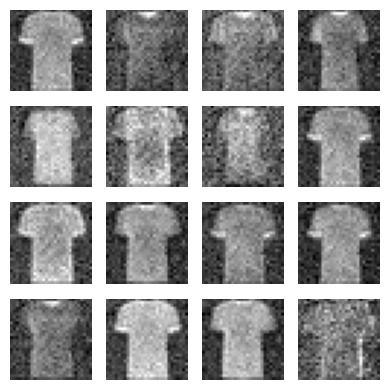

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 257ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step
FID Score: 2.283596308329536e+46


In [13]:
@tf.function
def train_step(images, labels):
    batch_size = tf.shape(images)[0]
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, labels], training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        disc_loss = cross_entropy(tf.ones_like(real_output), real_output) + \
                    cross_entropy(tf.zeros_like(fake_output), fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

epochs = 500
batch_size = 128

dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(60000).batch(batch_size)

for epoch in range(epochs):
    for image_batch, label_batch in tqdm(dataset):
        train_step(image_batch, label_batch)
    
    print(f'Epoch {epoch + 1}/{epochs}')

num_examples_to_generate = 16
noise = tf.random.normal([num_examples_to_generate, 100])
random_labels = tf.random.uniform([num_examples_to_generate], minval=0, maxval=2, dtype=tf.int32)
generated_images = generator([noise, random_labels], training=False)

fig = plt.figure(figsize=(4, 4))

for i in range(num_examples_to_generate):
    plt.subplot(4, 4, i+1)
    plt.imshow(generated_images[i, :, :, 0] * 0.5 + 0.5, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

def calculate_fid(real_images, generated_images):
    inception_model = tf.keras.applications.InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
    
    def preprocess_images(images):
        images = tf.image.resize(images, (299, 299))
        images = tf.image.grayscale_to_rgb(images)
        return images
    
    real_images = preprocess_images(real_images)
    generated_images = preprocess_images(generated_images)
    
    real_activations = inception_model.predict(real_images)
    generated_activations = inception_model.predict(generated_images)
    
    mu1, sigma1 = np.mean(real_activations, axis=0), np.cov(real_activations, rowvar=False)
    mu2, sigma2 = np.mean(generated_activations, axis=0), np.cov(generated_activations, rowvar=False)
    
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = linalg.sqrtm(sigma1.dot(sigma2))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

num_images_for_fid = 1000
noise = tf.random.normal([num_images_for_fid, 100])
random_labels = tf.random.uniform([num_images_for_fid], minval=0, maxval=2, dtype=tf.int32)
generated_images = generator([noise, random_labels], training=False)

fid = calculate_fid(test_images[:num_images_for_fid], generated_images)
print(f"FID Score: {fid}")